### CNN Neural Network

#### 1. Data, Module, Hyperparameter Setting

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [2]:
DATA_IN_PATH = './Text_Classification/data_in/'
DATA_OUT_PATH = './Text_Classification/data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [3]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [4]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 4
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
         'vocab_size' : prepro_configs['vocab_size'],
         'embedding_size' : 128,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dimension' : 250,
         'output_dimension' : 1}

In [6]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation=tf.keras.activations.relu,
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                                activation=tf.keras.activations.relu,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

#### Generate Model

In [7]:
model = CNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

#### Model Training

In [10]:
# overfitting을 막기 위한 earlystopping
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('{} -- Folder create completed \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', 
                              verbose=1, save_best_only=True, save_weights_only=True)

./Text_Classification/data_out/cnn_classifier_en -- Folder already exists 



In [11]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/4
44/44 [==============================] - 3s 58ms/step - loss: 0.3522 - accuracy: 0.8506 - val_loss: 0.3027 - val_accuracy: 0.8760

Epoch 00001: val_accuracy improved from -inf to 0.87600, saving model to ./Text_Classification/data_out/cnn_classifier_en\weights.h5
Epoch 2/4
44/44 [==============================] - 3s 58ms/step - loss: 0.2094 - accuracy: 0.9188 - val_loss: 0.3256 - val_accuracy: 0.8716

Epoch 00002: val_accuracy did not improve from 0.87600


#### Graph

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

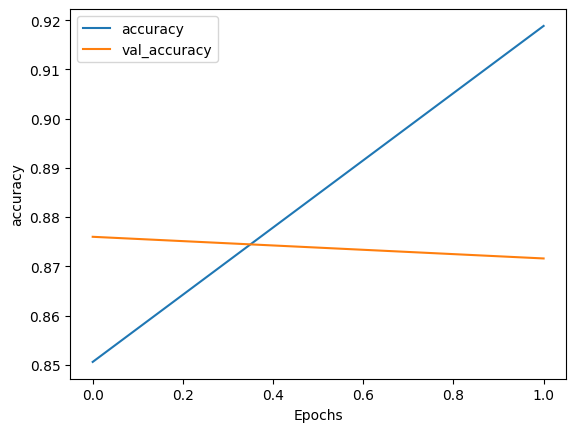

In [17]:
plot_graphs(history, 'accuracy')

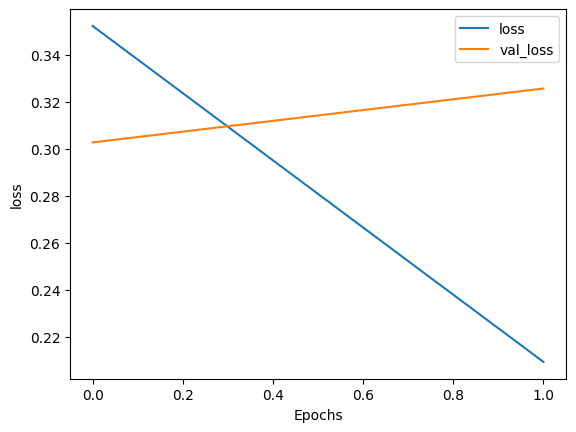

In [18]:
plot_graphs(history, 'loss')

#### Data Submission

In [19]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [20]:
# 최고 성능
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [21]:
# 테스트 데이터 예측
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [22]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame(data={'id':list(test_id), 'sentiments':list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)